In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

import seaborn as sns
from sklearn.metrics import confusion_matrix


In [3]:
# Load data 4 ps
data_path = '../Data/Preprocessed data/'

#Read events from the dataframe
events_s1 = pd.read_pickle(data_path + 'Subject001/' + 'behaviour_s001.pickle').reset_index(drop=True) # this reset should be done in the preprocess code
# events_s2 = pd.read_pickle(data_path + 'Subject002/' + 'behaviour_s002.pickle').reset_index(drop=True) # this reset should be done in the preprocess code
events_s3 = pd.read_pickle(data_path + 'Subject003/' + 'behaviour_s003.pickle').reset_index(drop=True) # this reset should be done in the preprocess code
events_s4 = pd.read_pickle(data_path + 'Subject004/' + 'behaviour_s004.pickle').reset_index(drop=True) # this reset should be done in the preprocess code


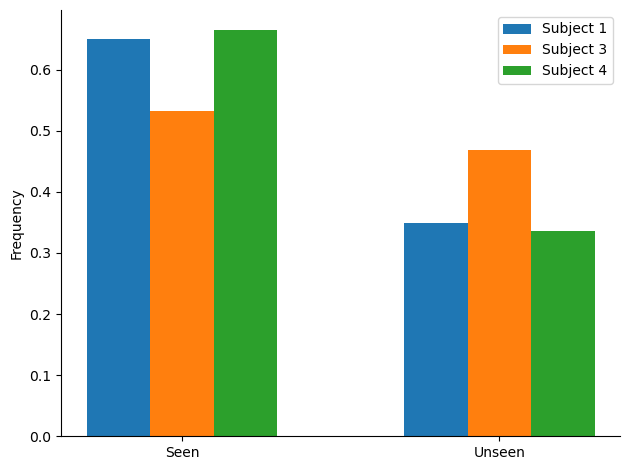

In [9]:
# Plot frequency of Seen/Unseen trials (R3: have you seen the stimuli?)

# extract events that showed a target
events_seen_s1 = events_s1.query("Target==1 and Mask==1") # before: query("Target==1 and Mask==1")
# events_seen_s2 = events_s2.query("Target==1")
events_seen_s3 = events_s3.query("Target==1 and Mask==1")
events_seen_s4 = events_s4.query("Target==1 and Mask==1")

# count proportion of seen/unseen (see R3 column)
freq_s1 = events_seen_s1.R3.value_counts()/events_seen_s1.R3.count()
# freq_s2 = events_seen_s2.R3.value_counts()/events_seen_s2.R3.count()
freq_s3 = events_seen_s3.R3.value_counts()/events_seen_s3.R3.count()
freq_s4 = events_seen_s4.R3.value_counts()/events_seen_s4.R3.count()

# List of labels
labels = ['Seen', 'Unseen']
subjects = ['Subject 1', 'Subject 3', 'Subject 4']

# list of values (participants)
values = [freq_s1, freq_s3, freq_s4]

# plot
fig, ax = plt.subplots()
width = 0.2  # Width of each bar
for i, value in enumerate(values):
    x = [j + i * width for j in range(len(labels))]
    ax.bar(x, value, width, label=subjects[i])

ax.set_xticks([j + width for j in range(len(labels))])
ax.set_xticklabels(labels)
ax.set_ylabel('Frequency')
sns.despine()
ax.legend()
fig.tight_layout()

plt.show()


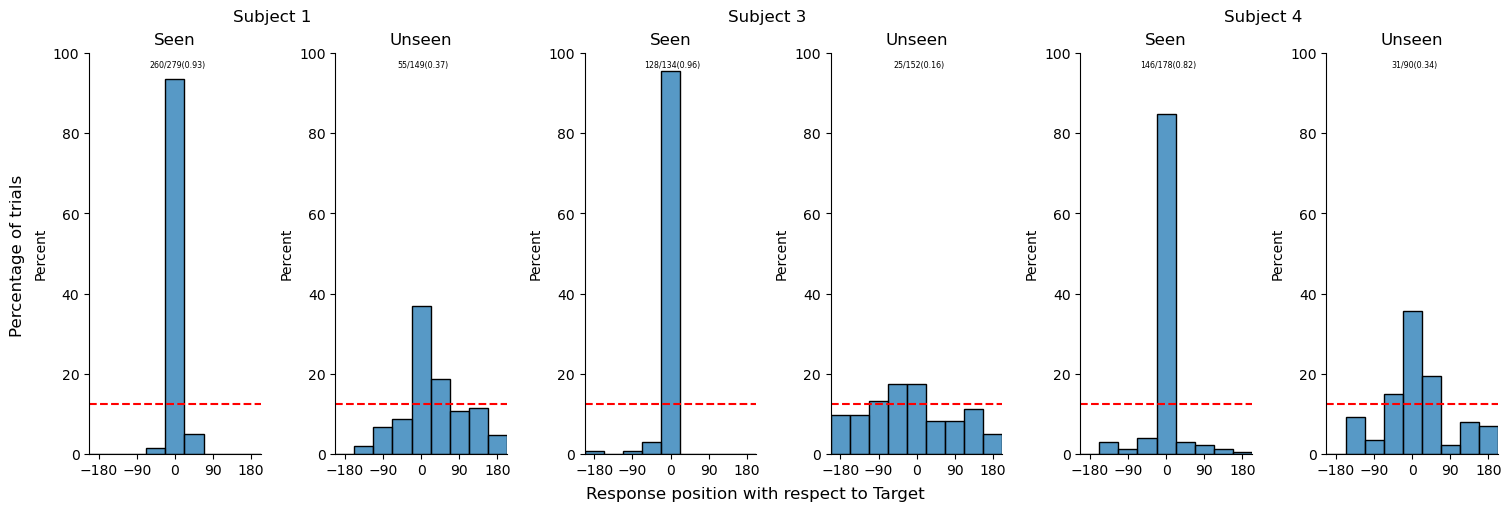

In [15]:
# plot histogram location for seen and unseen trials

# function to compute number of correct trials for seen/unseen conditions
def correct_trials_ratio(df, trial):
    if trial == 'Seen':
        r3 = 1
    elif trial == 'Unseen': 
        r3 = 0
    correct = len(df[(df['Correct'] == 1) & (df['R3'] == r3) & (df['Target'] == 1) & (df['Mask']==1)])
    total = len(df[(df['R3'] == r3) & (df['Target'] == 1)& (df['Mask']==1)]) #.dropna(subset='R1')) # KEY TO MY NIGHTMARE, There are trials that ps didnt respond, don't count these! why not? aren't they just unseen?
    percentage = correct/total

    return correct, total, round(percentage,2)

def position_to_angle(position):
    # Each position is 45 degrees apart, starting from 0 degrees
    return (position - 1) * 360/8

def angle_difference(df):
    # target
    target_seen = df.loc[(df['R3'] == 1) & (df['Target'] == 1) & (df['Mask']==1), 'Location'].to_numpy()
    target_unseen = df.loc[(df['R3'] == 0) & (df['Target'] == 1)& (df['Mask']==1), 'Location'].to_numpy()
    # response
    response_seen = df.loc[(df['R3'] == 1) & (df['Target'] == 1)& (df['Mask']==1), 'R1'].to_numpy()
    response_unseen = df.loc[(df['R3'] == 0) & (df['Target'] == 1)& (df['Mask']==1), 'R1'].to_numpy()

    # convert location to angle
    target_angle_seen = position_to_angle(target_seen)
    target_angle_unseen = position_to_angle(target_unseen)

    response_angle_seen = position_to_angle(response_seen)
    response_angle_unseen = position_to_angle(response_unseen)

    # compute angle different in the range [-180, 180]
    diff_seen = response_angle_seen-target_angle_seen
    diff_seen = np.where(diff_seen > 180, diff_seen - 360, diff_seen)
    diff_seen = np.where(diff_seen < -180, diff_seen + 360, diff_seen)

    diff_unseen = response_angle_unseen-target_angle_unseen
    diff_unseen = np.where(diff_unseen > 180, diff_unseen - 360, diff_unseen)
    diff_unseen = np.where(diff_unseen < -180, diff_unseen + 360, diff_unseen)


    return diff_seen, diff_unseen


# Plot
data = [events_s1[1:], events_s3, events_s4]
subj_labels = ['Subject 1', 'Subject 3', 'Subject 4']

bin_edges = np.linspace(-202.5, 202.5, 10)  # 10 edges for 9 bins (from -180 to 180). 180 + 45/2, to have bars centered
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2  # Centers of the bins
chance = 1/8

fig = plt.figure(constrained_layout=True, figsize=(15,5))
subfigs = fig.subfigures(1,3)

for i, subfig in enumerate(subfigs):
    subj = data[i]
    subfig.suptitle(subj_labels[i])

    diff_seen, diff_unseen = angle_difference(subj)
    
    ax1 = subfig.add_subplot(1, 2, 1)
    sns.histplot(diff_seen, bins=bin_edges, stat='percent')
    ax1.set(xlim=(-202.5, 202.5), ylim=(0,100),title='Seen', xticks=[-180, -90, 0, 90, 180])
    ax1.axhline(chance*100, c='r', ls='--')
    correct, total, percentage = correct_trials_ratio(subj, 'Seen')
    ax1.text(5, 97, f'{correct}/{total}({percentage})', horizontalalignment='center', verticalalignment='center', fontsize=5.7)
    sns.despine()

    ax2 = subfig.add_subplot(1, 2, 2)
    sns.histplot(diff_unseen, bins=bin_edges, stat='percent')
    ax2.set(xlim=(-202.5,202.5), ylim=(0,100),title='Unseen', xticks=[-180, -90, 0, 90, 180])
    ax2.axhline(chance*100, c='r', ls='--')
    correct, total, percentage = correct_trials_ratio(subj, 'Unseen')
    ax2.text(5, 97, f'{correct}/{total}({percentage})', horizontalalignment='center', verticalalignment='center', fontsize=5.7)
    sns.despine()


fig.supxlabel('Response position with respect to Target')
fig.supylabel('Percentage of trials')
plt.show()


In [32]:
diff_seen, diff_unseen = angle_difference(events_s3)


def compute_chi_test(events):

    bins = np.linspace(-202.5, 157.5, 9)  # 9 edges for 8 bins (from -180 to 135) to not repeat 180 and -180

    diff_seen, diff_unseen = angle_difference(events)

    hist_seen, _ = np.histogram(diff_seen, bins=bins) # removes the nans for you
    hist_unseen, _ = np.histogram(diff_unseen, bins=bins)

    # print(len(diff_seen), sum(hist_seen))

    hist_seen_random = np.full(len(hist_seen), sum(hist_seen)/len(hist_seen)) # 1 over 8 possible targets, aka chance level. Random distribution for each location (chance level)
    hist_unseen_random = np.full(len(hist_unseen), sum(hist_unseen)/(len(hist_unseen))) 

    # Compute chi square test
    chi2_stat_seen, p_value_seen = scipy.stats.chisquare(f_obs=hist_seen, f_exp=hist_seen_random)
    chi2_stat_unseen, p_value_unseen = scipy.stats.chisquare(f_obs=hist_unseen, f_exp=hist_unseen_random)

    return chi2_stat_seen, p_value_seen, chi2_stat_unseen, p_value_unseen


for label, subj in zip(subj_labels ,data):
    _, pval_seen, _, pval_unseen = compute_chi_test(subj)
    # print(f'{label} pvalue Chi test: Seen trials {round(pval_seen)}, Unseen trials {round(pval_unseen, 3)}')
    print(f'{label} pvalue Chi test: Seen trials {pval_seen}, Unseen trials {pval_unseen}')


# SHOULD I RUN STATS IN 9 BINS OR 8? I WOULD SAY 8 cause -180 and 180 are the same thing, I only used that distinction for ploting purposes

Subject 1 pvalue Chi test: Seen trials 0.0, Unseen trials 1.2627296195535804e-22
Subject 3 pvalue Chi test: Seen trials 3.2196981454530993e-178, Unseen trials 0.10979752673029367
Subject 4 pvalue Chi test: Seen trials 2.3095448356176155e-175, Unseen trials 7.037306549413337e-13


IndexError: list index out of range

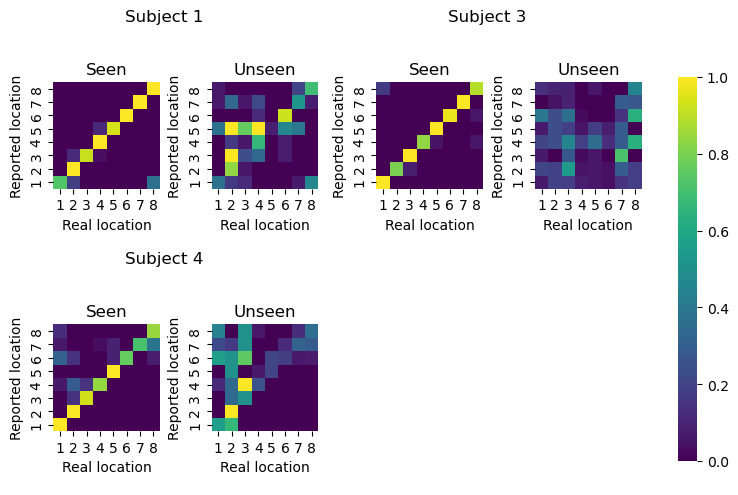

In [218]:
# Plot confusion matrix (reported location vs real location)

def conf_mat(data, query):
  '''
  Generate a confusion matrix filtering the data using a query
  '''
  df = data.query(query).dropna(subset='R1')
  labels_location, unique_location = pd.factorize(df.Location, sort=True) # convert locations (categorical labels) to numerical labels 
  labels_R1, unique_R1 = pd.factorize(df.R1, sort=True)

  cm = confusion_matrix(labels_location, labels_R1)
  if cm.shape[0]>8:
    C = cm[1:,1:].T
  else:
    C = cm.T
  return C

# plot 
fig = plt.figure(constrained_layout=True)
subfigs = fig.subfigures(2, 2)

cbar_ax = fig.add_axes([1.05, .05, .03, .8])

for i, subfig in enumerate(subfigs.flat):
    subj= data[i]
    subfig.suptitle(subj_labels[i])

    ax1 = subfig.add_subplot(1, 2, 1)
    mat = conf_mat(subj, "Target==1 and R3==1 and Mask==1")
    sns.heatmap(mat/np.sum(mat, axis=1), cmap='viridis', square=True, robust=True, xticklabels=range(1,9), yticklabels=range(1,9), vmin=0.0, vmax=1.0, cbar_ax=cbar_ax) # normalized by num of real locations
    ax1.set(xlabel='Real location', ylabel='Reported location', title= 'Seen')
    ax1.invert_yaxis()

    ax2 = subfig.add_subplot(1, 2, 2)
    mat = conf_mat(subj, "Target==1 and R3==0 and Mask==1")
    sns.heatmap(mat/np.sum(mat, axis=1), cmap='viridis', square=True, robust=True, xticklabels=range(1,9), yticklabels=range(1,9), vmin=0.0, vmax=1.0, cbar_ax=cbar_ax)
    ax2.set(xlabel='Real location', ylabel='Reported location', title= 'Unseen')
    ax2.invert_yaxis()

plt.show()


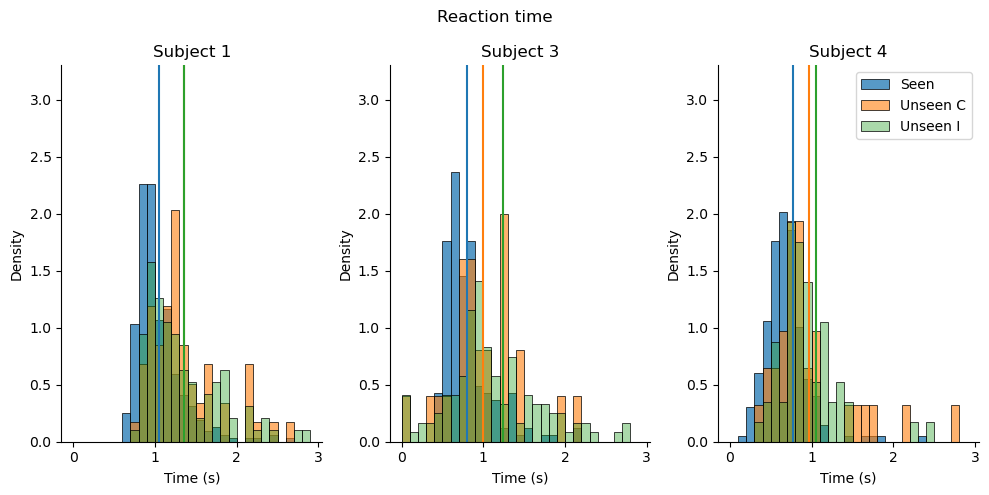

In [27]:
# Reaction times of report target (R1_RT) and SC, UI...

# get an array of reaction times, plot a prob distribution

def get_reaction_times(df):
    rt_seen = df.loc[(df['R3'] == 1) & (df['Target'] == 1), 'R1_RT'].to_numpy()
    rt_unseen = df.loc[(df['R3'] == 0) & (df['Target'] == 1), 'R1_RT'].to_numpy()
    rt_unseen_correct = df.loc[(df['Type'] == 'UC') & (df['Target'] == 1), 'R1_RT'].to_numpy()
    rt_unseen_incorrect = df.loc[(df['Type'] == 'UI') & (df['Target'] == 1), 'R1_RT'].to_numpy()

    return rt_seen, rt_unseen, rt_unseen_correct, rt_unseen_incorrect

# plot rts
fig = plt.figure(figsize=(10,5))

for i, subj in enumerate(data):
    ax = fig.add_subplot(1,3,i+1)
    rt_seen, rt_unseen, rt_uc, rt_ui = get_reaction_times(subj)
    bins= np.arange(0,3,0.1)
    sns.histplot(rt_seen, bins=bins, stat='density', label='Seen')
    # sns.histplot(rt_unseen, bins=bins, stat='density', label='Unseen')
    sns.histplot(rt_uc, bins=bins, stat='density', label='Unseen C', alpha=0.6)
    sns.histplot(rt_ui, bins=bins, stat='density', label='Unseen I', alpha=0.4)
    ax.set(title=subjects[i], xlabel='Time (s)', ylim=(0,3.3))
    ax.axvline(np.mean(rt_seen))
    ax.axvline(np.mean(rt_uc), c='C1')
    ax.axvline(np.mean(rt_ui), c='C2')
    fig.suptitle('Reaction time')
sns.despine()
plt.legend()
plt.tight_layout()
plt.show()

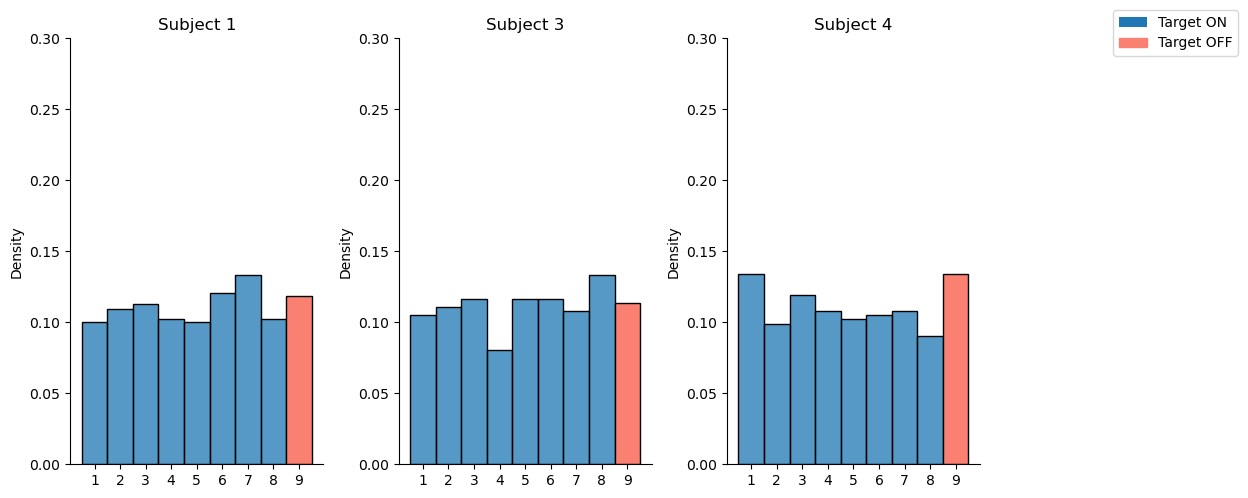

In [25]:
# Target distribution per participant ALL trials
targets_s1 = events_s1['Location'].values
# targets_s2 = events_s2['Location'].values
targets_s3 = events_s3['Location'].values
targets_s4 = events_s4['Location'].values

targets = [targets_s1, targets_s3, targets_s4]


def plot_target_distributions(targets):
    fig = plt.figure(figsize=(10,5))

    for i, target in enumerate(targets):
        ax = fig.add_subplot(1, 3, i+1)
        ax = sns.histplot(target, stat='density', discrete=True)
        ax.patches[-1].set_facecolor('salmon')
        ax.set_xticks(np.arange(1, 10, 1))
        ax.set(title=subjects[i], ylim=(0,0.3))


    # custom legend
    from matplotlib.patches import Rectangle
    legend_elements = [Rectangle((0, 0), 1, 1, label='Target ON'),
                    Rectangle((0, 0), 1, 1, color='salmon', label='Target OFF')]

    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1))

    # plt.legend(['Target ON', 'Target OFF'])
    sns.despine()
    plt.tight_layout()
    plt.show()


plot_target_distributions(targets)

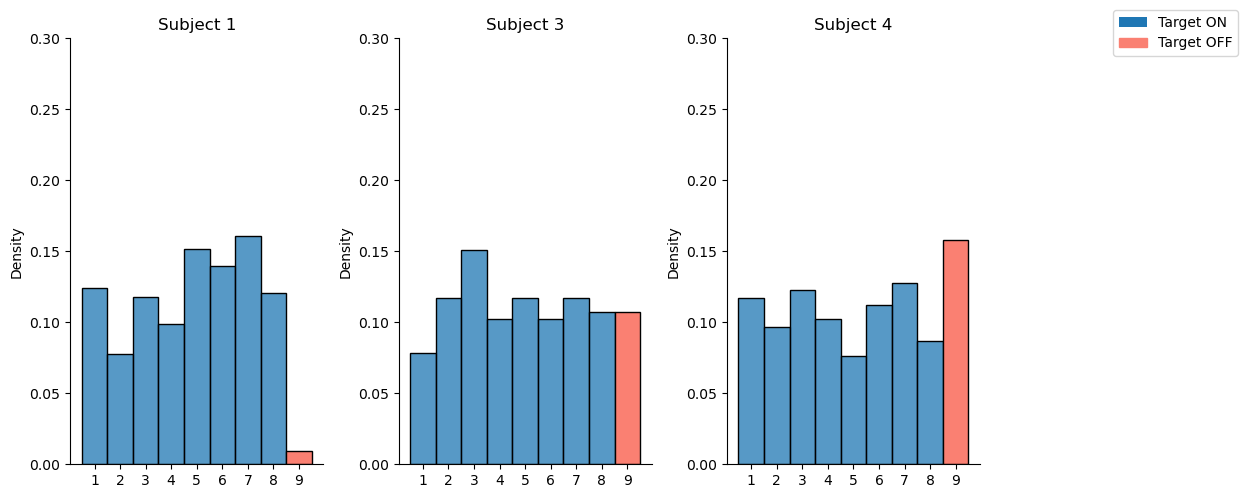

In [28]:
# Target distribution per participant SEEN (VS UNSEEN) TRIALS
targets_s1 = events_s1['Location'].values
targets_s1_seen = events_s1.loc[(events_s1['R3'] == 1), 'Location'].values
# targets_s2_seen = events_s2.loc[(events_s1['R3'] == 1), 'Location'].values
targets_s3_seen = events_s3.loc[(events_s1['R3'] == 1), 'Location'].values
targets_s4_seen = events_s4.loc[(events_s1['R3'] == 1), 'Location'].values


targets = [targets_s1_seen, targets_s3_seen, targets_s4_seen]

plot_target_distributions(targets)

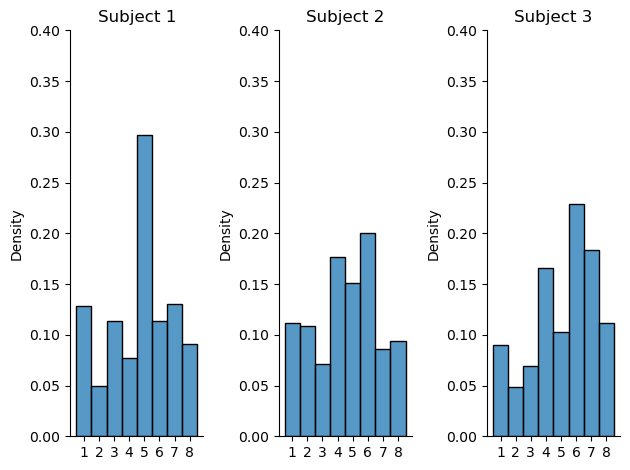

In [30]:
# Response target distribution per participant ALL trials
targets_s1 = events_s1['R1'].values
# targets_s2 = events_s2['R1'].values
targets_s3 = events_s3['R1'].values
targets_s4 = events_s4['R1'].values

targets = [targets_s1, targets_s3, targets_s4]

def plot_response_distributions(targets):
    fig = plt.figure()

    for i, target in enumerate(targets):
        ax = fig.add_subplot(1,3, i+1)
        ax = sns.histplot(target, stat='density', discrete=True)
        ax.set_xticks(np.arange(1, 9, 1))
        ax.set(title=f'Subject {i+1}', ylim=(0,0.40))

    sns.despine()
    plt.tight_layout()
    plt.show()

plot_response_distributions(targets)

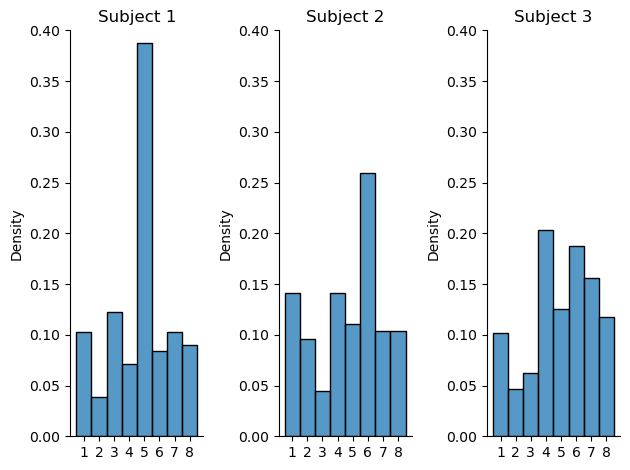

In [31]:
# Response target distribution per participant SEEN (VS UNSEEN) TRIALS
targets_s1_seen = events_s1.loc[(events_s1['R3'] == 0) & (events_s1['Location'] != 9), 'R1'].values
# targets_s2_seen = events_s2.loc[(events_s1['R3'] == 0)  & (events_s2['Location'] != 9), 'R1'].values
targets_s3_seen = events_s3.loc[(events_s1['R3'] == 0)  & (events_s3['Location'] != 9), 'R1'].values
targets_s4_seen = events_s4.loc[(events_s1['R3'] == 0)  & (events_s4['Location'] != 9), 'R1'].values

targets = [targets_s1_seen, targets_s3_seen, targets_s4_seen]

plot_response_distributions(targets)